Model sensitivity to different values of horizontal and vertical prescribed diffusivity coefficients.

Sensitivity to Explicit Diffusivity Coefficients
============================

This ipython notebook investigates the model sensitivity to different values of horizontal and vertical prescribed diffusivity coeffiecients. Experiment 360x360x90_BodyForcing_6tr_LinProfiles has upwelling body forcing. Run01 explores values of horizontal diffusivity (1E-7 to 50) with fixed vertical diffusivity (1E-5). Run02 explores values of vertical diffusivity (1E-7 to 10) keeping horizontal diffusivity fixed (1E-5).

In [27]:
#KRM
import os

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import nanmean

from math import *

%matplotlib inline

import numpy as np

import matplotlib.colors as mcolors

from netCDF4 import Dataset

import pylab as pl

from decimal import getcontext, Decimal, Inexact

import statsmodels.api as sm

import pandas as pd

In [28]:
#lib_path = os.path.abspath('../PythonModulesMITgcm') # Add absolute path to my python scripts
#sys.path.append(lib_path)

import NumDiffTools as dif

Important input parameters:
------------------------

In [29]:
nx = 360  # number of x points in domain
ny = 360  # number of y points in domain
nz = 90  # number of z levels in domain
nt = 10   # number of output files (n time) 
delt= 24*3600.0 # time interval between model output

Load output filenames:


In [30]:
### Load output filenames ###

filename = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_BodyForcing_6Tr_LinProfiles/run02/tave.0000000000.glob.nc'
StateOut = Dataset(filename)
#for dimobj in StateOut.variables.values():
#    print dimobj

filename2 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_BodyForcing_1Tr/run01/mnc_0001/grid.t001.nc'
GridOut = Dataset(filename2)
#for dimobj in GridOut.variables.values():
#    print dimobj

filename3 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_BodyForcing_6Tr_LinProfiles/run02/ptr_tave.0000000000.glob.nc'
PtracersOut = Dataset(filename3)
#for dimobj in PtracersOut.variables.values():
#    print dimobj


Make some plots 

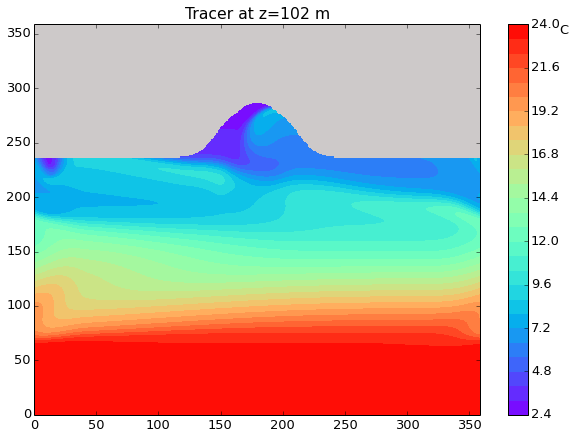

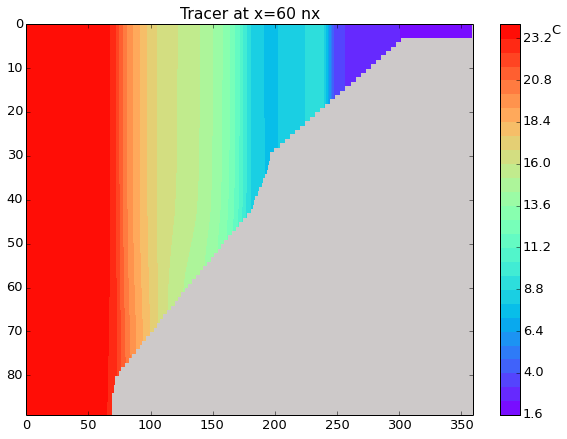

In [31]:
tracer1 = dif.getField(filename3,'Tr5')

tracer1msk = np.ma.masked_values(tracer1, 0)

MASK = np.ma.getmask(tracer1msk)
   
    
### PLOT TRACER 1 at zlev and time###

zlev =20
time =9

plt.rcParams.update({'font.size':13})
plt.figure(figsize=(10,7))

ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.contourf(tracer1msk[time,zlev,:,:],30, cmap='rainbow')
cb = plt.colorbar()
cb.set_label('C', position=(0, 1),rotation=0)

z=StateOut.variables['Z']

plt.title("Tracer at z=%d m" % -z[zlev])

 
plt.figure(figsize=(10,7))

ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.contourf(tracer1msk[time,:,:,60],30, cmap='rainbow')
plt.gca().invert_yaxis()
cb = plt.colorbar()
cb.set_label('C', position=(0, 1),rotation=0)

z=StateOut.variables['Z']

plt.title("Tracer at x=60 nx")




Calculate the volume of the domain
-------------------------------
The volume of a tracer cell (remember we have an Arakawa C grid, so this changes depending on which kind of cell we are thinking about) is given by

$V(i,j,k)=depth \times area = (hfacC(i,j,k)\times dRf(k)) \times rA(i,j) = (hfacC(i,j,k)\times dRf(k)) \times dXg(i,j) \times dYg(i,j)$,

where hfacC is the fraction of the cell that is open (not occupied with land). So, the total volume of the domain is 

$\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(hfacC(i,j,k)\times dRf(k)) \times rA(i,j)}}}$

In [32]:
vol = dif.CalcDomVolume(filename2, nx, ny, nz)

DomVolume = vol[0]
hFacC = vol[1]
drF = vol[2]
rAC = vol[3]

print(DomVolume)

6.10285330794e+12


1st Term: The volume-weighted average of the squared concentration
-------------------------------------------------------------
The first term in the variance evolution equation is $\frac{1}{2}\frac{\partial{\overline{q^{2}}}}{\partial{t}}$. Note that we care about the time derivative of the variance, so that the mean concentration that usually appears in the definition of variance will not play a role here, since it is constant in time (we are not putting in or letting out any tracer). 

We are going to calculate $\overline{q^2}$, the volume-weighted average of the squared concentration, and then the time derivative of that using a centered difference scheme.

In [33]:
q2mean = dif.CalcVariance(nt, nz, ny, nx, DomVolume, hFacC, drF, rAC, tracer1)

dqdt = dif.CalcTimeDer(q2mean, nt, delt)


2nd Term: The volume-weighted average of the squared horizontal gradient
------------------------------------------------------------------
The second term in the variance evolution equation is $-\kappa_{h} \overline{|\nabla_h q|^2}$. Next, we calculate the square of the horizontal gradient $|\nabla_h q|^2=(\frac{\partial{q}}{\partial{x}})^2+(\frac{\partial{q}}{\partial{y}})^2$.

Spatial derivatives are approximated using a centered-difference scheme.

In [34]:
qmeanDh = dif.CalcAvgHorGrad(filename2, nt,nz,ny,nx,tracer1,DomVolume,hFacC, drF, rAC)

3rd Term: The volume-weighted average of the squared vertical derivative
------------------------------------------------------------------
The third term in the variance evolution equation is $-\kappa_{v} \overline{(\frac{\partial{q}}{\partial{z}})^2}$. Next, we calculate the square of the vertical gradient $(\frac{\partial{q}}{\partial{z}})^2$.

The vertical derivative is approximated using a centered-difference scheme.

In [35]:
qmeanDz=dif.CalcAvgVerGrad(filename2, nt,nz,ny,nx,tracer1,DomVolume,hFacC, drF, rAC)

Tracer variance plots:
--------------------

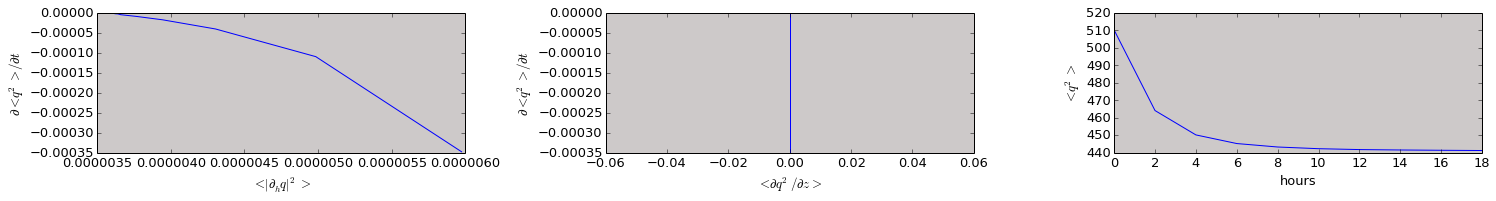

In [36]:

fig1=plt.figure(figsize=(21,3))

plt.subplot(1,3,1)
ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(qmeanDh[1:len(qmeanDh)-1],dqdt)


plt.xlabel('$<|\partial_{h}q|^2>$')

plt.ylabel('$\partial{<q^2>}/\partial{t}$')
    

plt.subplot(1,3,2)
ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(qmeanDz[1:len(qmeanDz)-1],dqdt)


plt.xlabel('$<\partial{q^2}/\partial{z}>$')

plt.ylabel('$\partial{<q^2>}/\partial{t}$')

plt.subplot(1,3,3)
ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(np.arange(0,nt*2,2.0),q2mean)

plt.xlabel('hours')

plt.ylabel('$<q^2>$')

plt.tight_layout()

Linear regression for $\kappa_h$ and $\kappa_v$
------------------------------------------

In the regression results box, x1 corresponds to $\kappa_h$ and x2 to $\kappa_v$.

In [37]:
est1=dif.FitDiffusivity(-qmeanDh[1:len(qmeanDh)-1],dqdt[0:len(dqdt)], delt)
print(est1.params)

est2=dif.FitDiffusivity(-qmeanDz[1:len(qmeanDh)-1],dqdt[0:len(dqdt)], delt)
print(est2.params)


[-9.84632794]
[ 0.]
